In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import matplotlib.cm as cm
from scipy.misc import imresize
import cv2
import pandas as pd
import scipy.io as io

In [2]:
def data_extraction(path_left, path_right):
    img_path_left = glob(path_left + '/*.jpg')
    img_path_right = glob(path_right + '/*.jpg')
    img_path_left.sort()
    img_path_right.sort()
    data_right = []
    data_left = []
    for i in range(len(img_path_left)):
        img_left = cv2.imread(img_path_left[i], 0)
        img_right = cv2.imread(img_path_right[i], 0)
        data_left.append(img_left)
        data_right.append(img_right)
    return [data_right, data_left]

In [3]:
def label_extraction(path, screen_path):
    txt = pd.read_csv(path, sep = ' ', header= None)
    screen = io.loadmat(screen_path)
    df_anno = pd.DataFrame(txt)
    data_frame = pd.DataFrame()
    data_frame['Screen_x'] = df_anno[:][24] / screen['width_pixel'][0][0]
    data_frame['Screen_y'] = df_anno[:][25] / screen['height_pixel'][0][0]
    return data_frame

In [4]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [5]:
def path_optimization(day_list, path):
    all_path = []
    cnt = 0
    for i in range(len(day_list)): # 15번 
        temp = []
        for j in range(day_list[i]):
            temp.append(path[cnt])
            cnt += 1
        all_path.append(temp)
    return all_path

In [6]:
def make_dataset_img_label(image_shape, label_shape, data_list, label_list):
    length = len(data_list[0])
    left_img = np.zeros([length,image_shape])
    right_img = np.zeros([length,image_shape])
    label = np.zeros([length,label_shape])
    for n in range(length):
        left_img[n, :] = data_list[1][n].reshape(image_shape)
        right_img[n, :] = data_list[0][n].reshape(image_shape)
        label[n, :] = [label_list['Screen_x'][n], label_list['Screen_y'][n]]
        
    return right_img, left_img, label

def make_dataset_gaze_pose(data_shape, data_list):
    length = len(data_list[0])
    left_pose = np.zeros([length,data_shape])
    right_pose = np.zeros([length,data_shape])
    left_gaze = np.zeros([length,data_shape])
    right_gaze = np.zeros([length,data_shape])
    for n in range(length):
        left_gaze[n, :] = data_list[3][n]
        right_gaze[n, :] = data_list[2][n]
        left_pose[n, :] = data_list[5][n]
        right_pose[n, :] = data_list[4][n]
    return left_gaze, right_gaze, left_pose, right_pose

In [7]:
image_path_right = glob('/home/spow12/Codes/Data/MPIIGaze/Data/Our_data_right/*/*/')
image_path_left = glob('/home/spow12/Codes/Data/MPIIGaze/Data/Our_data_left/*/*/')
image_path_left.sort()
image_path_right.sort()

In [8]:
day_list = [39, 69, 39, 65, 25, 38, 62, 56, 47, 20, 16, 19, 7, 12, 7]  
image_path_left_op = path_optimization(day_list, image_path_left)
image_path_right_op = path_optimization(day_list, image_path_right)

label_path = glob('/home/spow12/Codes/Data/MPIIGaze/Data/Original/*/*/annotation.txt') # 521개
label_path.sort()
label_path = path_optimization(day_list, label_path)
#label_path = path_optimzation(glob('C:/MPIIGaze/MPIIGaze/Data/Original/*/*/annotation.txt'))
screen_size_path = glob('/home/spow12/Codes/Data/MPIIGaze/Data/Original/*/Calibration/screenSize.mat') # 15개

In [9]:
for i in range(15): # 총 15명
    data = [] # 사람별로 나눈 데이터
    label = [] # 사람별로 나눈 라벨   
    for j in range(day_list[i]): # 각 사람에 맞는 day만큼
        data.append(data_extraction(image_path_left_op[i][j], image_path_right_op[i][j]))
        label.append(label_extraction(label_path[i][j], screen_size_path[i]))
    exec('p%d_data = data' % (i))
    exec('p%d_label = label' % (i))

In [10]:
Batch_RE_img_data = []
Batch_LE_img_data = []
#Batch_LE_gaze_data = []
#Batch_RE_gaze_data = [] 
#Batch_LE_pose_data = []
#Batch_RE_pose_data = []
Batch_label = []
for i in range(15):
    for j in range(day_list[i]): #days list in Data  po -> 39days  ..
        exec('RE_img_data, LE_img_data, dataset_label = make_dataset_img_label(36 * 60, 2, p{0}_data[{1}], p{2}_label[{3}])'
             .format(i, j, i, j))
        Batch_RE_img_data.append(RE_img_data)
        Batch_LE_img_data.append(LE_img_data)
#         Batch_LE_gaze_data.append(LE_gaze_data)
#         Batch_RE_gaze_data.append(RE_gaze_data)
#         Batch_LE_pose_data.append(LE_pose_data)
#         Batch_RE_pose_data.append(RE_pose_data)
        Batch_label.append(dataset_label)

In [11]:
for i in range(15):
    exec('del(p{0}_data)'.format(i))
    exec('del(p{0}_label)'.format(i))

In [12]:
del(RE_img_data)
del(LE_img_data)
del(dataset_label)
del(image_path_right)
del(image_path_left)
del(label_path)
del(screen_size_path)
del(data)
del(label)

# Make dataset

In [128]:
train = day_list[:7]
val = day_list[9:]
#val = day_list[7:9]
test = day_list[7:9]

print(sum(train))
print(sum(train_2))
#print(sum(val))
print(sum(test))

337
81
103


In [129]:
d_len = [0, 337, 418, 521]

In [130]:
all_ls = []

In [69]:
# cnt = 0
# for i in range(418, 521):
#     for j in range(len(Batch_LE_img_data[i])):
#         cnt += 1
        
# all_ls.append(cnt)

In [167]:
all_ls = [169054, 20573, 24031]

In [17]:
def build_data(idx, batch, data=[Batch_LE_img_data,Batch_RE_img_data, Batch_label], day_ls = d_len, n = 0):
    LE_image = np.zeros([batch[idx], 36, 60, 1])
    RE_image = np.zeros([batch[idx], 36, 60, 1])
    label = np.zeros([batch[idx], 2])
    
    try:
        for i in range(day_ls[idx], day_ls[idx + 1]):
            for j in range(len(data[0][i])):
                LE_image[n, :] = data[0][i][j].reshape(36, 60, 1)
                RE_image[n, :] = data[1][i][j].reshape(36, 60, 1)
                label[n, :] = data[2][i][j]
                n += 1
    except IndexError:
        pass
    return LE_image, RE_image, label#, i, n

In [18]:
LE_train_image, RE_train_image, train_label = build_data(idx = 0, batch=all_ls) 
LE_test_image, RE_test_image, test_label = build_data(idx = 1, batch=all_ls)    
LE_train_image_2, RE_train_image_2, train_label_2= build_data(idx = 2, batch=all_ls)

# Make graph for eye images

In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Dropout
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import Dense, Flatten, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Input
# from morph_net.network_regularizers import flop_regularizer
# from morph_net.tools import structure_exporter
# from morph_net.framework import batch_norm_source_op_handler
from tensorflow.keras.layers import DepthwiseConv2D
from tensorflow.keras.layers import AveragePooling2D

In [161]:
def Build_conv2d(x, channel, name, num,down_sampling=False):
    stride= (2, 2) if down_sampling else (1, 1)
    #padd = '' if down_sampling else 'same'
    with tf.name_scope(name + '_layer_'+num):
        x = (Conv2D(channel, kernel_size=(3, 3), padding= 'same',
                        kernel_initializer='he_uniform', use_bias= False,
                        strides = stride ,activation= None,
                        name = name +'_Layer_'+num))(x)
        x = (BatchNormalization(name = name +'_BN_'+ num))(x)
        x = (Activation('elu', name = name +'_act_'+num))(x)
        return x

In [162]:
def build_net(ch, shape, drop = 0.3):
    row, col, channel = shape[0], shape[1], shape[2]
    left_input = Input(shape=(row, col, channel,), name = 'left_eye_input')
    right_input = Input(shape=(row, col, channel,), name= 'right_eye_input')
    channel_1 = ch[0]
    channel_2 = ch[1]
    channel_3 = ch[2]
    channel_4 = ch[3]
    channel_5 = ch[4]
    channel_6 = ch[5]
    name = 'Left'
    with tf.name_scope(name +'_layer_1'):
        x = Conv2D(channel_1, kernel_size=(3, 3), 
                    padding="same", 
                    use_bias= False,
                    kernel_initializer='he_uniform',
                    strides = (1, 1),activation= None,
                    name = 'Left_Layer_1')(left_input)
#         x = (BatchNormalization(name = 'Left_BN_1'))(x)
#         x = Activation('elu', name = 'Left_act')(x)
    x = Build_conv2d(x,channel_2, name, '2', down_sampling=True)
    x = Build_conv2d(x,channel_2, name, '3', down_sampling=False)
    x = Build_conv2d(x,channel_3, name, '4', down_sampling=True)
    x = Build_conv2d(x,channel_3, name, '5', down_sampling=False)
    x = Build_conv2d(x,channel_4, name, '6', down_sampling=True)
    x = Build_conv2d(x,channel_4, name, '7', down_sampling=False)
    x = Build_conv2d(x,channel_5, name, '8', down_sampling=True)
    x = Build_conv2d(x,channel_5, name, '9', down_sampling=False)
    x = Build_conv2d(x,channel_6, name, '10', down_sampling=True)
    x = Build_conv2d(x,channel_6, name, '11', down_sampling=False)
    left_x = AveragePooling2D([2, 2],name= "Left_global_avg_pool")(x)

    name = 'Right'
    with tf.name_scope(name +'_layer_1'):
        x = (Conv2D(channel_1, kernel_size=(3, 3), padding="same",
                    kernel_initializer='he_uniform',
                    use_bias= False,
                    strides = (1, 1),activation= None,
                    name = 'Right_Layer_1'))(right_input)
#         x = (BatchNormalization(name = 'Right_BN_1'))(x)
#         x = Activation('elu', name='Right_act')(x)
    x = Build_conv2d(x,channel_2, name, '2', down_sampling=True)
    x = Build_conv2d(x,channel_2, name, '3', down_sampling=False)
    x = Build_conv2d(x,channel_3, name, '4', down_sampling=True)
    x = Build_conv2d(x,channel_3, name, '5', down_sampling=False)
    x = Build_conv2d(x,channel_4, name, '6', down_sampling=True)
    x = Build_conv2d(x,channel_4, name, '7', down_sampling=False)
    x = Build_conv2d(x,channel_5, name, '8', down_sampling=True)
    x = Build_conv2d(x,channel_5, name, '9', down_sampling=False)
    x = Build_conv2d(x,channel_6, name, '10', down_sampling=True)
    x = Build_conv2d(x,channel_6, name, '11', down_sampling=False)
    right_x = AveragePooling2D([2,2],name = "Right_global_avg_pool")(x)


    merge_layer = concatenate([left_x, right_x])
    merged = Flatten()(merge_layer)

    with tf.name_scope('merge_layer_1'):
        x = (Dense(320, name = 'Merge_dense_1', kernel_initializer='he_uniform'))(merged)
        x = (BatchNormalization(name = 'Merge_BN_1'))(x)
        x = (Activation('elu', name = 'Merge_act_1'))(x)
        x = (Dropout(drop, name = 'Merge_drop_1'))(x)

    with tf.name_scope('merge_layer_out'):
        x = (Dense(40, name = 'Merge_dense_out',kernel_initializer='he_uniform'))(x)
        x = BatchNormalization(name = 'Merge_BN_out')(x)
        x = Activation('elu', name = 'Merge_act_out')(x)
        out = Dense(2, name = 'OUT', activation = 'linear')(x)    

    model = Model([left_input, right_input], out)
    return model

In [163]:
def Build_conv2D_with_ds_pw(x, channel, name, num, down_sampling=False):
    s = (2, 2) if down_sampling else (1, 1)
    with tf.name_scope(name +'_layer_'+num):
        x = DepthwiseConv2D((3, 3), strides= s, padding='same', use_bias=False, 
                            activation= None, kernel_initializer='he_uniform',
                            name = name +'_DS_'+num)(x)
        x = BatchNormalization(name = name +'_DS_BN_'+num)(x)
        x = (Activation('elu', name = name +'_DS_act_'+num))(x)
        x = Conv2D(channel, (1, 1), strides=(1, 1), padding='same', use_bias=False, 
                            activation= None, kernel_initializer='he_uniform',
                            name = name +'_PW_'+num)(x)
        x = BatchNormalization(name = name +'_PW_BN_'+num)(x)
        x = (Activation('elu', name = name +'_PW_act_'+num))(x)
    return x

In [164]:
def build_net_with_mobile(ch, shape, drop= 0.3):
    row, col, channel = shape[0], shape[1], shape[2]
    left_input = Input(shape=(row, col, channel,), name = 'left_eye_input')
    right_input = Input(shape=(row, col, channel,), name= 'right_eye_input')
    channel_1 = ch[0]
    channel_2 = ch[1]
    channel_3 = ch[2]
    channel_4 = ch[3]
    channel_5 = ch[4]
    channel_6 = ch[5]
    name = 'Left'
    with tf.name_scope(name +'_layer_1'):
        x = (Conv2D(channel_1, kernel_size=(3, 3), padding="same", 
                            strides = (1, 1),activation= None,
                            use_bias= False,
                            kernel_initializer='he_uniform',
                            name = 'Left_Layer_1'))(left_input)
#         x = (BatchNormalization(name = 'Left_BN_1',use_bias=False))(x)
#         x = Activation('elu')(x)
        
    x = Build_conv2D_with_ds_pw(x,channel_2, name, '2', down_sampling=True)
    x = Build_conv2D_with_ds_pw(x,channel_2, name, '3', down_sampling=False)
    x = Build_conv2D_with_ds_pw(x,channel_3, name, '4', down_sampling=True)
    x = Build_conv2D_with_ds_pw(x,channel_3, name, '5', down_sampling=False)
    x = Build_conv2D_with_ds_pw(x,channel_4, name, '6', down_sampling=True)
    x = Build_conv2D_with_ds_pw(x,channel_4, name, '7', down_sampling=False)
    x = Build_conv2D_with_ds_pw(x,channel_5, name, '8', down_sampling=True)
    x = Build_conv2D_with_ds_pw(x,channel_5, name, '9', down_sampling=False)
    x = Build_conv2D_with_ds_pw(x,channel_6, name, '10', down_sampling=True)
    x = Build_conv2D_with_ds_pw(x,channel_6, name, '11', down_sampling=False)
    left_x = AveragePooling2D([2, 2],name= "Left_global_avg_pool")(x)

    
    name = 'Right'
    
    with tf.name_scope(name +'_layer_1'):
        x = (Conv2D(channel_1, kernel_size=(3, 3), padding="same", 
                            strides = (1, 1),activation= None,
                            kernel_initializer='he_uniform',
                            use_bias= False,
                            name = 'Right_Layer_1'))(right_input)
#         x = (BatchNormalization(name = 'Right_BN_1',use_bias=False))(x)
#         x = Activation('elu')(x)
    x = Build_conv2D_with_ds_pw(x,channel_2, name, '2', down_sampling=True)
    x = Build_conv2D_with_ds_pw(x,channel_2, name, '3', down_sampling=False)
    x = Build_conv2D_with_ds_pw(x,channel_3, name, '4', down_sampling=True)
    x = Build_conv2D_with_ds_pw(x,channel_3, name, '5', down_sampling=False)
    x = Build_conv2D_with_ds_pw(x,channel_4, name, '6', down_sampling=True)
    x = Build_conv2D_with_ds_pw(x,channel_4, name, '7', down_sampling=False)
    x = Build_conv2D_with_ds_pw(x,channel_5, name, '8', down_sampling=True)
    x = Build_conv2D_with_ds_pw(x,channel_5, name, '9', down_sampling=False)
    x = Build_conv2D_with_ds_pw(x,channel_6, name, '10', down_sampling=True)
    x = Build_conv2D_with_ds_pw(x,channel_6, name, '11', down_sampling=False)
    right_x = AveragePooling2D([2,2],name = "Right_global_avg_pool")(x)


    merge_layer = concatenate([left_x, right_x])
    merged = Flatten()(merge_layer)

    with tf.name_scope('merge_layer_1'):
        x = (Dense(320, name = 'Merge_dense_1', kernel_initializer='he_uniform'))(merged)
        x = (BatchNormalization(name = 'Merge_BN_1'))(x)
        x = (Activation('elu', name = 'Merge_act_1'))(x)
        x = (Dropout(drop, name = 'Merge_drop_1'))(x)

    with tf.name_scope('merge_layer_out'):
        x = (Dense(40, name = 'Merge_dense_out',kernel_initializer='he_uniform'))(x)
        x = BatchNormalization(name = 'Merge_BN_out')(x)
        x = Activation('elu', name = 'Merge_act_out')(x)
        out = Dense(2, name = 'OUT', activation = 'linear')(x)    
    model = Model([left_input, right_input], out)
    return model

In [165]:
def save_model(model, train_history, path, name):
    model_json = model.to_json()
    graph = path+ '_' + name + '.json'
    weight = path+ '_' + name + '.h5'
    history = path + '_' + name + '.csv'
    with open(graph, "w") as f: 
        f.write(model_json)
        f.close()

    model.save_weights(weight)
    print("Saved model to disk")

    hist = pd.DataFrame(train_history.history)
    hist.to_csv(history)

In [111]:
LE_Train = LE_train_image[:169000]
RE_Train = RE_train_image[:169000]
Label_train = train_label[:169000]

LE_Test = LE_train_image_2[:24000]
RE_Test = RE_train_image_2[:24000]
Label_Test = train_label_2[:24000]

LE_val = LE_test_image[:20500]
RE_val = RE_test_image[:20500]
Label_val = test_label[:20500]

In [168]:
tf.reset_default_graph()
shape = [36, 60, 1]
channel_ls = [10, 20, 40 ,80, 120, 160]

In [169]:
model = build_net(channel_ls, shape, drop = 0.3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_eye_input (InputLayer)     [(None, 36, 60, 1)]  0                                            
__________________________________________________________________________________________________
right_eye_input (InputLayer)    [(None, 36, 60, 1)]  0                                            
__________________________________________________________________________________________________
Left_Layer_1 (Conv2D)           (None, 36, 60, 10)   90          left_eye_input[0][0]             
__________________________________________________________________________________________________
Right_Layer_1 (Conv2D)          (None, 36, 60, 10)   90          right_eye_input[0][0]            
______________________________________________________________________________________________

In [170]:
show_graph(tf.get_default_graph())

In [105]:
epoch = 5
batch_size = 100

In [106]:
opt = Adam(lr=1e-4, decay=1e-3 / 200)
model.compile(loss = 'mse', optimizer= opt)

In [107]:
train_history = model.fit([LE_Train, RE_Train], Label_train, epochs= epoch, batch_size= batch_size,  verbose= 1,
                    validation_data=([LE_val, RE_val],Label_val))

Train on 169000 samples, validate on 20500 samples
Epoch 1/5
169000/169000 [==============================] - 477s 3ms/sample - loss: 0.0911 - val_loss: 0.0968
Epoch 2/5
169000/169000 [==============================] - 468s 3ms/sample - loss: 0.0228 - val_loss: 0.0846
Epoch 3/5
169000/169000 [==============================] - 453s 3ms/sample - loss: 0.0162 - val_loss: 0.0778
Epoch 4/5
169000/169000 [==============================] - 436s 3ms/sample - loss: 0.0129 - val_loss: 0.0699
Epoch 5/5
169000/169000 [==============================] - 244s 1ms/sample - loss: 0.0108 - val_loss: 0.0711


In [110]:
model.evaluate([LE_Test, RE_Test], Label_Test)

24000/24000 [==============================] - 7s 308us/sample - loss: 0.0637


0.06368077351028721

In [115]:
#plot_history(train_history)

In [112]:
path = "/home/spow12/Codes/temp/model"
save_model(model, train_history, path, "default")

Saved model to disk


In [132]:
tf.reset_default_graph()
model_with_ds_pw = build_net_with_mobile(channel_ls, shape, drop = 0.3)
model_with_ds_pw.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_eye_input (InputLayer)     [(None, 36, 60, 1)]  0                                            
__________________________________________________________________________________________________
right_eye_input (InputLayer)    [(None, 36, 60, 1)]  0                                            
__________________________________________________________________________________________________
Left_Layer_1 (Conv2D)           (None, 36, 60, 10)   90          left_eye_input[0][0]             
__________________________________________________________________________________________________
Right_Layer_1 (Conv2D)          (None, 36, 60, 10)   90          right_eye_input[0][0]            
______________________________________________________________________________________________

In [125]:
#show_graph(tf.get_default_graph())

In [133]:
opt = Adam(lr=1e-4, decay=1e-3 / 200)
model_with_ds_pw.compile(loss = 'mse', optimizer= opt)

In [134]:
train_history_ds_pw = model_with_ds_pw.fit([LE_Train, RE_Train], Label_train, epochs= epoch, batch_size= batch_size,  verbose= 1,
                    validation_data=([LE_val, RE_val],Label_val))

Train on 169000 samples, validate on 20500 samples
Epoch 1/5
169000/169000 [==============================] - 238s 1ms/sample - loss: 0.1352 - val_loss: 0.0944
Epoch 2/5
169000/169000 [==============================] - 234s 1ms/sample - loss: 0.0352 - val_loss: 0.0848
Epoch 3/5
169000/169000 [==============================] - 234s 1ms/sample - loss: 0.0240 - val_loss: 0.0832
Epoch 4/5
169000/169000 [==============================] - 234s 1ms/sample - loss: 0.0183 - val_loss: 0.0761
Epoch 5/5
169000/169000 [==============================] - 234s 1ms/sample - loss: 0.0148 - val_loss: 0.0734


In [158]:
model_with_ds_pw.evaluate([LE_test_image, RE_test_image], test_label)

20573/20573 [==============================] - 7s 352us/sample - loss: 0.0733


0.07328921431783385

In [137]:
path = "/home/spow12/Codes/temp/model"
save_model(model_with_ds_pw, train_history_ds_pw, path = path, name='mobile')

Saved model to disk


In [138]:
train_history_ds_pw.history

{'loss': [0.13516862562488346,
  0.03521084070161602,
  0.024029959266531398,
  0.018255422556409117,
  0.014822078741172097],
 'val_loss': [0.0943884749601527,
  0.08478925862326854,
  0.0831892773327304,
  0.07609452581623706,
  0.07343106984001835]}

In [159]:
def plot_history(history_1, history_2):
    hist = pd.DataFrame(history_1.history)
    hist_dw = pd.DataFrame(history_2.history)
    hist['epoch'] = history_1.epoch

    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['loss'],
           label='Standard CNN TE ')
    plt.plot(hist['epoch'], hist['val_loss'],
           label='Standard CNN VE')
    plt.plot(hist['epoch'], hist_dw['loss'],
            label = 'Depthwise Seperable CNN TE')
    plt.plot(hist['epoch'], hist_dw['val_loss'],
            label = 'Depthwise Seperable CNN VE')
    plt.ylim([0,0.15])
    plt.xticks([0, 1, 2, 3, 4])
    plt.legend()
    plt.show()


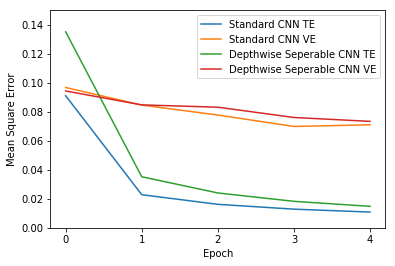

In [160]:
plot_history(train_history, train_history_ds_pw)

In [89]:
train_history.history

{'loss': [0.8320099576161458,
  0.29915816130546424,
  0.15363204311101863,
  0.12175095224609742,
  0.11740176549706703],
 'mean_absolute_error': [0.72682554,
  0.45842487,
  0.29699638,
  0.22273375,
  0.20393984]}

In [ ]:
"""
from tensorflow.keras.models import model_from_json 
json_file = open("/home/spow12/Codes/temp/Graphes/model_shrink_1.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("/home/spow12/Codes/temp/Variables/model_shrink_1.h5")
print("Loaded model from disk")

loaded_model.compile(loss = 'mse', optimizer= opt, 
                     metrics=['mean_absolute_error'])
score = loaded_model.evaluate([LE_test_image, RE_test_image],test_label ,
                              verbose=1)
"""

In [ ]:
# from tensorflow_model_optimization.sparsity import keras as sparsity

In [ ]:
"""tf.reset_default_graph()

end_step = np.ceil(1.0 * len(LE_train_image) / batch_size).astype(np.int32) * epoch
print(end_step)

new_pruning_params = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,
                                                   final_sparsity=0.90,
                                                   begin_step=0,
                                                   end_step=end_step,
                                                   frequency=100)
}
model_for_pruned = build_net(channel_ls, shape)
new_pruned_model = sparsity.prune_low_magnitude(model_for_pruned, **new_pruning_params)
new_pruned_model.summary()

new_pruned_model.compile(loss = 'mse', optimizer= opt, metrics=['mean_absolute_error'])
callbacks = [sparsity.UpdatePruningStep()]
#score = new_pruned_model.evaluate([LE_test_image, RE_test_image], test_label, verbose=0)"""

In [ ]:
# train_history_pruned = new_pruned_model.fit([LE_train_image, RE_train_image], train_label, epochs= epoch, batch_size= batch_size, 
#                           validation_data=([LE_val_image, RE_val_image], val_label), verbose= 1, callbacks=callbacks)

In [ ]:
# model_json = new_pruned_model.to_json()
# with open("/home/spow12/Codes/temp/Graphes/model_pruned.json', "w") as f: 
#     f.write(model_json)
#     f.close()

# model.save_weights("/home/spow12/Codes/temp/Variables/model_pruned.h5" +".h5")
# print("Saved model to disk")
          
# hist = pd.DataFrame(train_history_pruned.history)
# hist.to_csv('/home/spow12/Codes/temp/Variables/model_pruned.csv')

# plot_history(train_history_pruned)